In [1]:
import numpy as np
from pong_lookback_net import * 
from pong_recurrent_convolution_net import * 
import h5py
import subprocess
import matplotlib.pyplot as plt
from theano import * 
import theano.tensor as T

%load_ext autoreload
%autoreload 2

%matplotlib inline

config.floatX = 'float32'

In [4]:
# load Lookback model and weights

model = LookbackNet(window=4,batch_size=128,height=32,width=32)
model.load_weights('weights/lookback-large.HDF5')

KeyError: "Unable to open object (Object 'wfc2' doesn't exist)"

In [2]:
# Load RCN model and weights

model = PongRCNN(8,1,32,32)
model.load_weights('weights/rcn-large.HDF5')

pong_recurrent_convolution_net.py:48: UserWarning: pool_2d() will have the parameter ignore_border default value changed to True (currently False). To have consistent behavior with all Theano version, explicitly add the parameter ignore_border=True. On the GPU, using ignore_border=True is needed to use CuDNN. When using ignore_border=False and not using CuDNN, the only GPU combination supported is when `ds == st and padding == (0, 0) and mode == 'max'`. Otherwise, the convolution will be executed on CPU.
  self.POOL = T.signal.pool.pool_2d(self.LSTM_RCN2.output,(2,2))


In [33]:
# create Theano function to maximize activation at each RCN filter
rcn1_filtermaps_iterate = []

for f in range(4):
    output = model.LSTM_RCN1.output
    max_act_objective = T.mean(output[:,:,f,:,:])
    grads = T.grad(max_act_objective, model.Q)[0]
    grads /= T.sqrt(T.mean(T.square(grads))) + 1e-5
    iterate = function([model.Q],[max_act_objective,grads])
    rcn1_filtermaps_iterate.append(iterate)

In [43]:
rcn1_filtermaps = []
step = 1e-1


for f in range(4):

    #print "optimizing filter %i" % (f) 
    input_img_data = np.random.random((8, 1, 32, 32)).astype(np.float32)

    for i in range(1000):
        loss_value, grads_value = rcn1_filtermaps_iterate[f](input_img_data)
        input_img_data += grads_value * step
        
    rcn1_filtermaps.append(np.array(input_img_data))
        
    

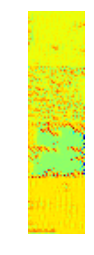

In [47]:
conc_img_data = []
for fm in rcn1_filtermaps: 
    
    conc_img_data.append(np.mean(fm[:],axis=0).squeeze())
    #print conc_img_data.squeeze().shape

all_fs = np.concatenate(conc_img_data[:],axis=0)
plt.axis('off')
plt.imshow(all_fs.squeeze())
plt.savefig('rcn-layer1-filters.png',bbox_inches='tight')

In [48]:
# create Theano function to maximize activation at each RCN filter, second layer
rcn2_filtermaps_iterate = []

for f in range(8):
    output = model.LSTM_RCN2.output
    max_act_objective = T.mean(output[:,:,f,:,:])
    grads = T.grad(max_act_objective, model.Q)[0]
    grads /= T.sqrt(T.mean(T.square(grads))) + 1e-5
    iterate = function([model.Q],[max_act_objective,grads])
    rcn2_filtermaps_iterate.append(iterate)
    
rcn2_filtermaps = []
step = 1e-1


for f in range(8):

    #print "optimizing filter %i" % (f) 
    input_img_data = np.random.random((8, 1, 32, 32)).astype(np.float32)

    for i in range(1000):
        loss_value, grads_value = rcn2_filtermaps_iterate[f](input_img_data)
        input_img_data += grads_value * step
        
    rcn2_filtermaps.append(np.array(input_img_data))

conc_rcn2_data = []
for fm in rcn2_filtermaps: 
    
    conc_rcn2_data.append(np.mean(fm[:],axis=0).squeeze())
    #print conc_img_data.squeeze().shape

all_fs = np.concatenate(conc_rcn2_data[:],axis=0)
plt.axis('off')
plt.imshow(all_fs.squeeze())
plt.savefig('rcn-layer2-filters.png',bbox_inches='tight')

NameError: name 'rcn2_filtermaps' is not defined

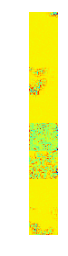

In [49]:
rcn2_filtermaps = []
step = 1e-1


for f in range(8):

    #print "optimizing filter %i" % (f) 
    input_img_data = np.random.random((8, 1, 32, 32)).astype(np.float32)

    for i in range(1000):
        loss_value, grads_value = rcn2_filtermaps_iterate[f](input_img_data)
        input_img_data += grads_value * step
        
    rcn2_filtermaps.append(np.array(input_img_data))



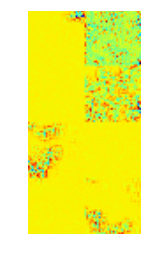

In [56]:
conc_rcn2_data = []
for fm in rcn2_filtermaps: 
    
    conc_rcn2_data.append(np.mean(fm[:],axis=0).squeeze())
    #print conc_img_data.squeeze().shape

all_fs = np.concatenate(conc_rcn2_data[:],axis=0)
all_fs = np.concatenate([all_fs[0:128], all_fs[128:]],axis=1)
plt.axis('off')
plt.imshow(all_fs.squeeze())
plt.savefig('rcn-layer2-filters.png',bbox_inches='tight')

In [ ]:
# create Theano function to maximize activation at each final unit -- SUPER SLOW METHOD REQUIRES COMPILING 1024 functions
final_filtermaps_iterate = {}

for i in range(32):
    for j in range(32): 
        output = model.output
        max_act_objective = T.mean(output[:,:,i,j])
        grads = T.grad(max_act_objective, model.Q,consider_constant=[model.P])[0]
        grads /= T.sqrt(T.mean(T.square(grads))) + 1e-5
        final_filtermaps_iterate[(i,j)] = function([model.Q,model.P],[max_act_objective,grads])
    


In [4]:
# create Theano function to maximize activation at each final unit
grads = {}
output = model.output


for i in range(32):
    for j in range(32): 
        max_act_objective = T.mean(output[:,:,i,j])
        grads[(i,j)] = T.grad(max_act_objective, model.Q,consider_constant=[model.P])[0]
        grads[(i,j)] /= T.sqrt(T.mean(T.square(grads[(i,j)]))) + 1e-5

        


ValueError: Cannot join an empty list of tensors

In [ ]:
rows = [] 

for i in range(32):
    row_list = [grads[(i,j)] for j in range(32)]
    row = T.concatenate(row_list, axis=1)
    rows.append(row)
    
full = T.concatenate(rows, axis=0)
        

final_filtermaps_iterate = function([model.Q,model.P],[max_act_objective,full])
    


In [ ]:
final_filtermaps = {}
step = 1e-1

P = np.zeros((8,1,2)).astype(np.float32)


for i in range(32):
    for j in range(32):

        #print "optimizing filter %i" % (f) 
        input_img_data = np.random.random((8, 1, 32, 32)).astype(np.float32)

        for i in range(100):
            loss_value, grads_value = final_filtermaps_iterate[(i,j)](input_img_data,P)
            input_img_data += grads_value * step

        final_filtermaps[(i,j)] = np.array(input_img_data).squeeze()

conc_final_data = np.zeros((32*32,32*32))

for i in range(32):
    for j in range(32):
        conc_final_data[i*32:(i+1)*32, j*32:(j+1)*32] = final_filtermaps[(i,j)]



In [ ]:
all_fs = conc_final_data
plt.axis('off')
plt.imshow(all_fs.squeeze())
plt.savefig('rcn-final-filters.png',bbox_inches='tight')